In [392]:
import os
import pickle
import numpy as np
import pandas as pd

from scipy.io import loadmat
from scipy.signal import butter, filtfilt, resample

import matplotlib.pyplot as plt

from snn.resonator import create_excitatory_inhibitory_resonator
from utils import copy_filter_hp_to_other_clock_frequency

# EEG_FOLDER = f'../datasets/EEG_data_for_Mental_Attention_State_Detection'
data_root = "../datasets/kaggle_data/signal/"

trial = 4
channels=['AccV', 'AccAP', 'AccAP']
channel = channels[0]

fs = 128

bands = {
    '1': (1, 2),
    '2': (2, 3),
    '3': (3, 4),
    '4': (4, 5),
    '5': (5, 6),
    '6': (6, 7),
    '7': (7, 8),
    '8': (8, 9),
    '9': (9, 10),
    '10': (10, 11),
    '11': (11, 12),
    '12': (12, 13),
    '13': (13, 14),
    '14': (14, 15),
    '15': (15, 16),
}

In [393]:
# number of samples in the original and resampled signals
def resample_signal(f_new, f_source, data):
    n_samples_orig = data.shape[0]
    n_samples_new = int(n_samples_orig * f_new / f_source)

    # resample the signal
    return resample(data, n_samples_new)

def bp_filter(data, f_lo, f_hi, fs):
    """ Digital band pass filter (6-th order Butterworth)
    Args:
        data: numpy.array, time along axis 0
        (f_lo, f_hi): frequency band to extract [Hz]
        fs: sampling frequency [Hz]
    Returns:
        data_filt: band-pass filtered data, same shape as data """
    data_filt = np.zeros_like(data)
    f_ny = fs / 2.  # Nyquist frequency
    b_lo = f_lo / f_ny  # normalized frequency [0..1]
    b_hi = f_hi / f_ny  # normalized frequency [0..1]
    # band-pass filter parameters
    p_lp = {"N":6, "Wn":b_hi, "btype":"lowpass", "analog":False, "output":"ba"}
    p_hp = {"N":6, "Wn":b_lo, "btype":"highpass", "analog":False, "output":"ba"}
    bp_b1, bp_a1 = butter(**p_lp)
    bp_b2, bp_a2 = butter(**p_hp)
    data_filt = filtfilt(bp_b1, bp_a1, data, axis=0)
    data_filt = filtfilt(bp_b2, bp_a2, data_filt, axis=0)
    return data_filt


#  Function to read in the EEG data and extract the valid lead data, low and high pass filter and z-transform the data.
#  Returns a dataframe.
def get_EEG_data(data_root, filename):
    # Extract the data from one of these files.
    hz = fs
    #filename = 'eeg_record30.mat'
    mat = loadmat(f'{data_root}/{filename}')
    data = pd.DataFrame.from_dict(mat["o"]["data"][0,0])

    # Limit the data to the 7 valid EEG leads.
    dat = data.filter(list(range(3, 17)))
    dat.columns = list(range(1, 15))
    dat = dat.filter([1,2, 3, 4,5,6, 7, 8, 9,10,11,12,13,14,17], axis=1)
    labels = ['AccV','AccML', 'AccPL']  # FP2 should really be AF4
    dat.columns = labels


    # Filter the data, high pass 2 Hz, low pass 40 Hz.
    lo, hi = 2, 40
    # Do the filtering.
    datf = bp_filter(dat.to_numpy(), lo, hi, hz)

    # Convert back to a dataframe.
    dat = pd.DataFrame({c: datf[:, i] for i,c in enumerate(labels)})

    # Z-transform each column
    #dat = dat.apply(zscore)

    return dat

def get_trial_data(trial):
    dat = get_EEG_data(data_root, f'eeg_record{trial}.mat')
    return dat


def plot_spectrogram(data, channel_name, fs, fmin, fmax, show=True):
    # plot the spectrogram
    plt.figure(figsize=(14, 5))
    Sxx, freqs, bins, im = plt.specgram(data, NFFT=256, Fs=fs,
                                         noverlap=fs, cmap='jet')
    # plt.vlines([600, 1200], ymin=fmin, ymax=fmax, colors='black')
    plt.ylim(fmin, fmax)
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'ch={channel_name} fs={fs} band=({fmin} - {fmax})Hz')
    plt.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[bins[0], bins[-1], freqs[0], freqs[-1]],
               vmin=0, vmax=np.max(Sxx[(freqs >= fmin) & (freqs <= fmax)]))
    plt.colorbar()
    if show:
        plt.show()
    return Sxx


def fft_spectogram2bins(Sxx, window):
    bins_count = len(Sxx[0])//window + 1
    bin_sxx = np.zeros((15, bins_count))

    # dict to array
    for ch_i, (f_min, f_max) in enumerate(bands.values()):
        for i in range(bins_count):

            bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:(i+1)*window]) / (f_max - f_min)
        bin_sxx[ch_i][i] = np.sum(Sxx[f_min:f_max, i*window:]) / (f_max - f_min)

    return bin_sxx

def plot_bins(Sxx, duration, labels, annotate=True, rotate_annotate=False, show=True):
    fig, ax = plt.subplots(figsize=(14, 5))
    im = ax.imshow(Sxx, aspect='auto',
               cmap='jet', origin='lower',
               extent=[0, duration, 0, len(Sxx)]
               )

    ax.set_yticks(np.arange(len(Sxx)), labels=labels)
    if annotate:
        bin_size = duration / len(Sxx[0])
        rotation_degree = 90 * rotate_annotate
        for i in range(len(Sxx)):
            for j in range(len(Sxx[i])):
                text = ax.text(j * bin_size + bin_size*.5, i + .5,  f'{Sxx[i, j]:.4f}',
                               rotation=rotation_degree,
                               ha="center", va="center", color="white")

    fig.tight_layout()
    fig.colorbar(im, ax=ax)
    if show:
        plt.show()


def array_to_bins(array, N):
    bins = np.array_split(array, N)
    bin_sums = np.array([np.sum(bin) for bin in bins], dtype=np.int64)
    return bin_sums


def spikes_to_bands(spikes_spectrogram):
    bands_spectrogram = np.zeros((15, spikes_spectrogram.shape[1]))
    for i in range(15):
        bands_spectrogram[i] = np.sum(spikes_spectrogram[i:i+5], axis=0) / (768 + i*768)
    return bands_spectrogram


def spikes_event_spectrogram(clk_freq, events, window_ms):
    window = int(clk_freq/1000 * window_ms)
    N = events[-1] // window + 1
    bins = np.zeros(N, dtype=int)
    unique_indices, counts = np.unique(np.array(events) // window, return_counts=True)
    bins[unique_indices] = counts
    return bins


In [394]:
trial = "0b2b9bc455.csv"
trial_path = os.path.join(data_root,trial)
trial_data = pd.read_csv(trial_path, index_col=0, compression='gzip')


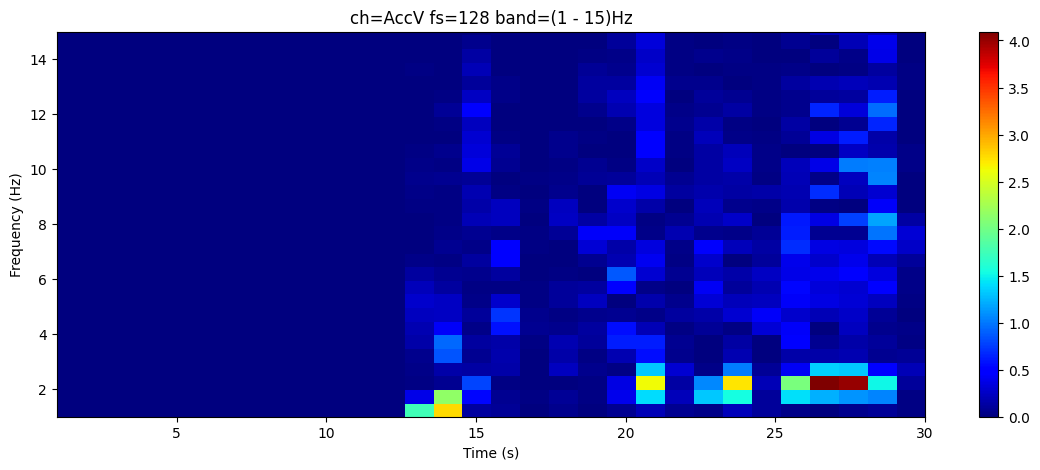

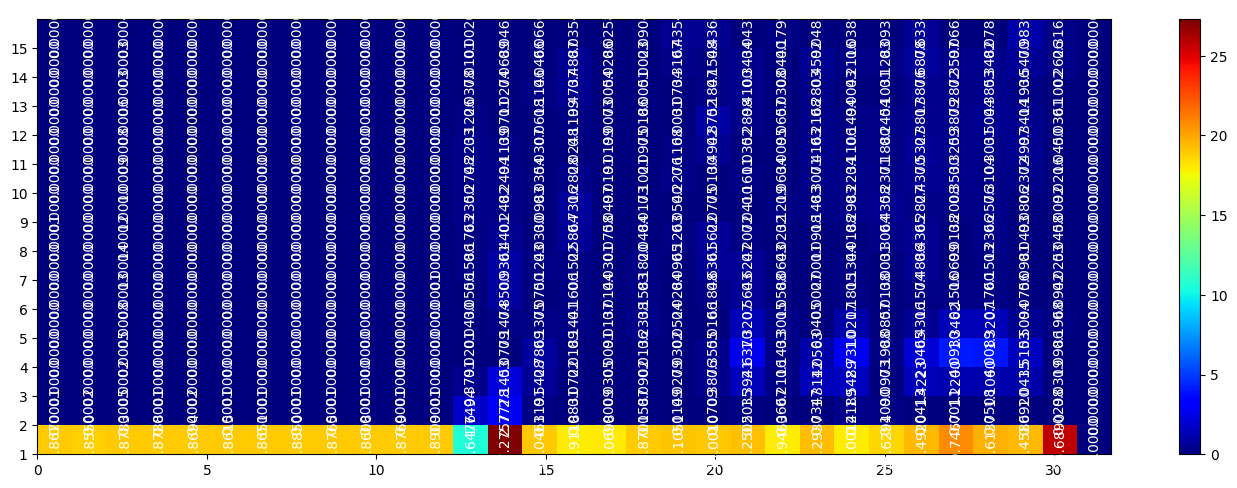

In [397]:
fft_spectogram = plot_spectrogram(trial_data[channel], channel_name=channel, fs=fs, fmin=1, fmax=15, show=False)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
plot_bins(fft_bin_spectogram, len(trial_data[channel])/fs, bands.keys(), annotate=True, rotate_annotate=True)

In [317]:
time_start_s = int(1500/fs)
time_end_s = int(len(trial_data[channel])/fs)
sliced_data = trial_data[channel][time_start_s*fs:time_end_s*fs]

Text(0.5, 1.0, 'Slice data on Time domain')

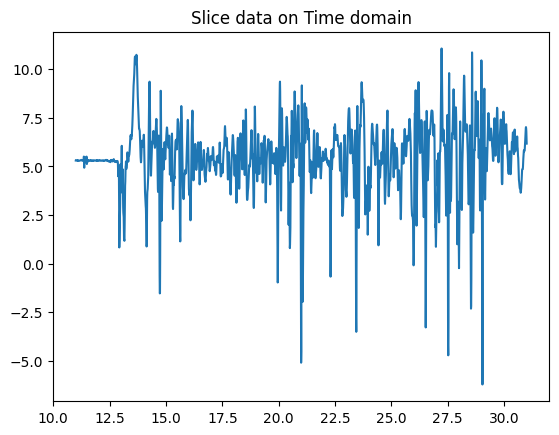

In [318]:
plt.plot(np.linspace(time_start_s, time_end_s, len(sliced_data)) , sliced_data)
plt.title('Slice data on Time domain')

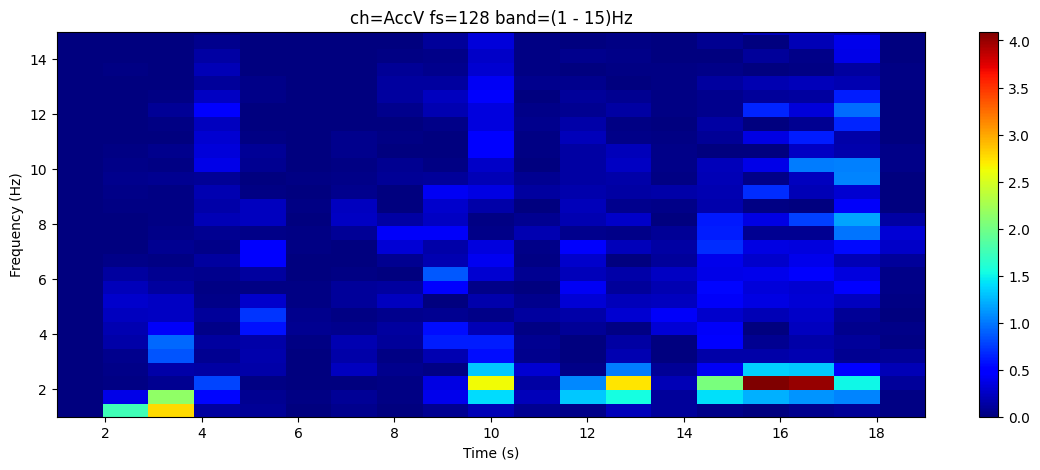

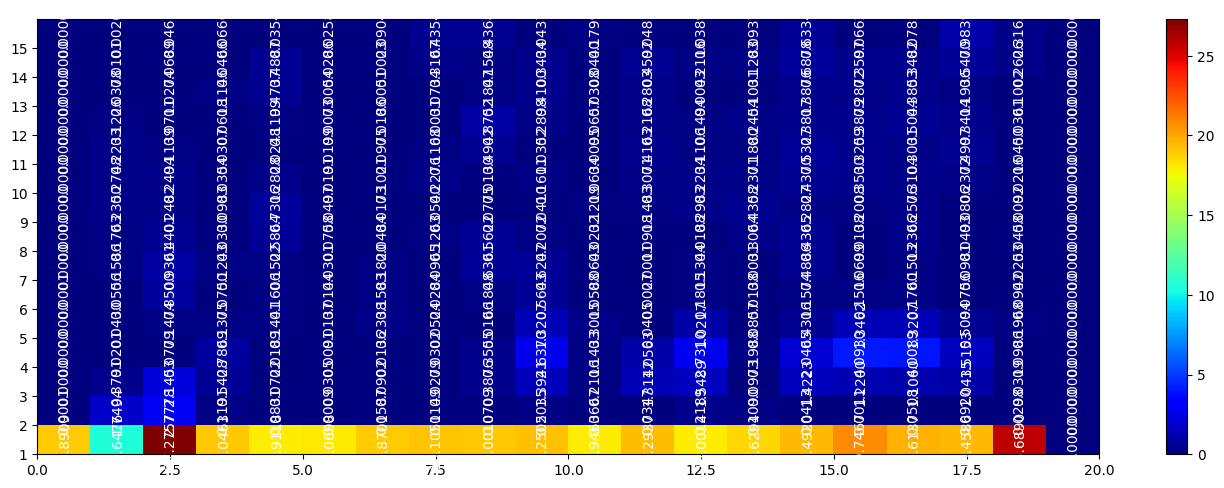

In [319]:
sliced_data = trial_data[channel][time_start_s*fs:time_end_s*fs]

fft_spectogram = plot_spectrogram(sliced_data, channel_name=channel, fs=fs, fmin=1, fmax=15, show=True)
fft_bin_spectogram = fft_spectogram2bins(fft_spectogram, 1)
plot_bins(fft_bin_spectogram, len(sliced_data)/fs, bands.keys(), rotate_annotate=True)

In [320]:
sliced_data /= np.max(np.abs(sliced_data))

In [321]:
clk_resonators = {
    15360: ['0.6', '1.0', '1.39', '1.64', '1.93'],
    30720: ['2.36','2.78','3.28','3.86'],
    61440: ['4.0','4.72','5.56','6.56','7.72'],
    122880: ['8.0','9.44','11.12','13.12', '15.44'],
    # 15360: ['0000.6', '0001.0', '001.39', '001.64', '001.93'],
    # 30720: ['002.36', '002.78', '003.28', '003.86'],
    # 61440: ['0004.0', '004.72', '005.56', '006.56'],
    # 122880: ['0008.0', '009.44', '011.12', '013.12','015.44']
}

In [322]:
from tqdm import tqdm

output = {}
with tqdm(total=20) as pbar:
    for clk_i, (clk_freq, list_of_f0) in enumerate(clk_resonators.items()):
        print(clk_freq)
        sliced_data_resampled = resample_signal(clk_freq, fs, sliced_data)
        output[clk_freq] = []
        for f_i, f0 in enumerate(list_of_f0):
            resonator = create_excitatory_inhibitory_resonator(
                freq0=f0,
                clk_freq=clk_freq)
            resonator.log_out_spikes(-1)
            output_neuron = resonator.layers_neurons[-1].neurons[-1]
            # append 5 seconds of zero to make the resonator converge.
            resonator.input_full_data(np.zeros(clk_freq * 5))
            resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output[clk_freq].append(output_neuron.out_spikes())
            pbar.update(1)

with open('../datasets/kaggle_data/signal/sliced_data_output.pickle', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)


  0%|          | 0/20 [00:00<?, ?it/s]

15360


 25%|██▌       | 5/20 [00:23<01:08,  4.60s/it]

30720


 45%|████▌     | 9/20 [00:57<01:24,  7.72s/it]

61440


 70%|███████   | 14/20 [02:15<01:25, 14.29s/it]

122880


 95%|█████████▌| 19/20 [04:59<00:15, 15.79s/it]


In [323]:
import pickle

with open('../datasets/kaggle_data/signal/sliced_data_output.pickle', 'rb') as f:
    output = pickle.load(f)

In [324]:
print((output[15360][0]))

[   349    451    551 ... 383852 383924 383997]


In [325]:
def create_spikes_list(data):
    max_value = data[-1]
    spikes = np.zeros(max_value + 1)
    spikes[data] = 1
    return spikes

15360
383998
382999


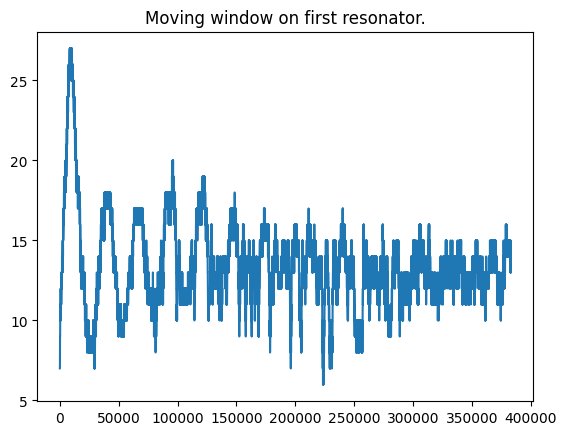

In [326]:
clk_freq = next(iter(output.keys()))
print(clk_freq)
y_spikes = create_spikes_list(output[clk_freq][0])
print(len(y_spikes))
y_spikes = np.convolve(y_spikes, np.ones(1000, dtype=int), 'valid')
print(len(y_spikes))
plt.plot(y_spikes)
plt.title('Moving window on first resonator.')
plt.show()

# y_spikes = output[clk_freq][0]
# spikes_spectrogram = np.zeros((1, len(y_spikes)//clk_freq*100))
# spikes_spectrogram[0] = array_to_bins(y_spikes, spikes_spectrogram.shape[1])
# plot_bins(spikes_spectrogram, spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False)
# plt.title('spikes in bins of 1ms.')
# plt.show()

In [327]:
# clk_freq = 15360
duration = 45
#
# events = output[clk_freq][0]
# spikes_spectrogram = np.zeros((1, (duration * 100)// 10))
# max_spikes_spectrogram = np.zeros((1, (duration * 100) // 100))
# spikes_spectrogram[0] = spikes_event_spectrogram(clk_freq, events, 10)
# max_spikes_spectrogram[0] = spikes_spectrogram[0].reshape(-1, len(spikes_spectrogram[0])//len(max_spikes_spectrogram[0])).max(axis=1)
#
# plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=['4.000'], annotate=False, show=False, rotate_annotate=True)
# plt.title('spikes in bins of 1s.')
# plt.show()

(2510,)
30
(2510,)
30
(2510,)
30
(2510,)
30
(2510,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30
(2502,)
30


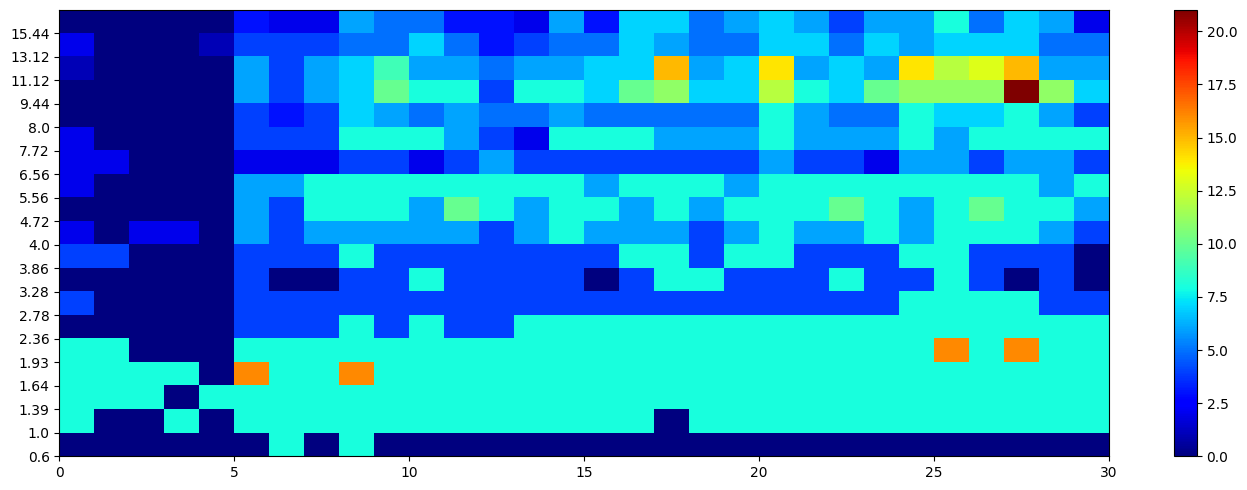

In [389]:
spikes_array = sum(output.values(), start=[])
clk_freq, values = next(iter(output.items()))
duration = 30

max_spikes_spectrogram = np.zeros((len(spikes_array), (duration * 1000) // 1000))

# axis 0 - resonators
# axis 1 - number of bins ( I set to 1ms)
main_clk = np.lcm.reduce(list(output.keys()))
i = 0
for clk_freq, spikes_arrays in output.items():
    for events in spikes_arrays:
        # spikes_spectrogram[i] = array_to_bins(spikes, spikes_spectrogram.shape[1])
        spikes_spectrogram = spikes_event_spectrogram(clk_freq, events, 10)
        print(spikes_spectrogram.shape)
        print(len(max_spikes_spectrogram[i]))
        spikes_spectrogram = spikes_spectrogram[-2400:]
        max_spikes_spectrogram[i] = spikes_spectrogram.reshape(-1, len(spikes_spectrogram)//len(max_spikes_spectrogram[i])).max(axis=1)
        max_spikes_spectrogram[i] -= np.min(max_spikes_spectrogram[i])
        max_spikes_spectrogram[i] *= (main_clk / clk_freq)
        i += 1

plot_bins(max_spikes_spectrogram, max_spikes_spectrogram.shape[1], labels=sum(clk_resonators.values(), []), annotate=False)

(15, 45)


Text(0.5, 1.0, 'Spikes ratio in 1 second')

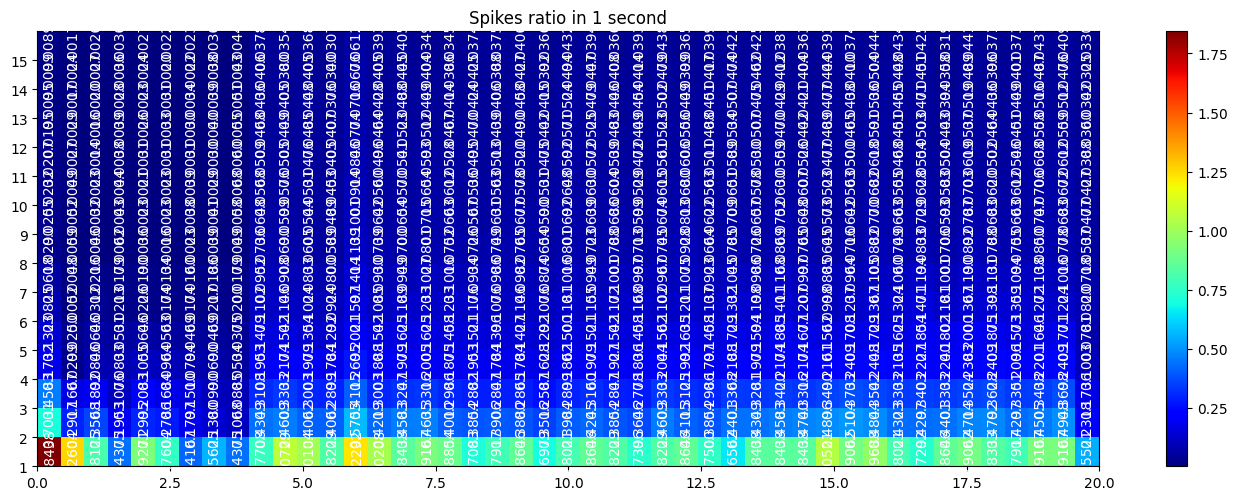

In [207]:
spikes_bands_spectrogram = spikes_to_bands(max_spikes_spectrogram)
print(spikes_bands_spectrogram.shape)
plot_bins(spikes_bands_spectrogram, len(sliced_data)/fs, labels=bands.keys(), annotate=True, rotate_annotate=True, show=False)
plt.title('Spikes ratio in 1 second')

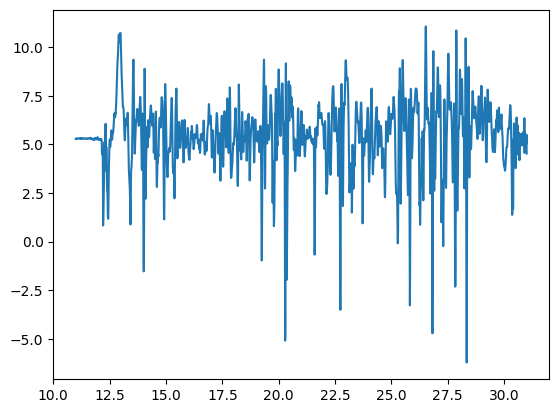

In [222]:
plt.plot(np.linspace(time_start_s, time_end_s, len(trial_data[channel][1500:])) , trial_data[channel][1500:])

In [225]:
import numpy as np
import pandas as pd

# Parameters
amplitude = 1.0
frequency = 1.0  # Frequency in Hz
sampling_rate = 1000  # Samples per second
duration = 5.0  # Duration in seconds

# Time axis
t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)

# Generate the sine wave
waveform = amplitude * np.sin(2 * np.pi * frequency * t)

# Create a DataFrame with the sampled data
df = pd.DataFrame({"Time": t, "Amplitude": waveform})

# Save the DataFrame as a CSV file
df.to_csv("sine_wave.csv", index=False)

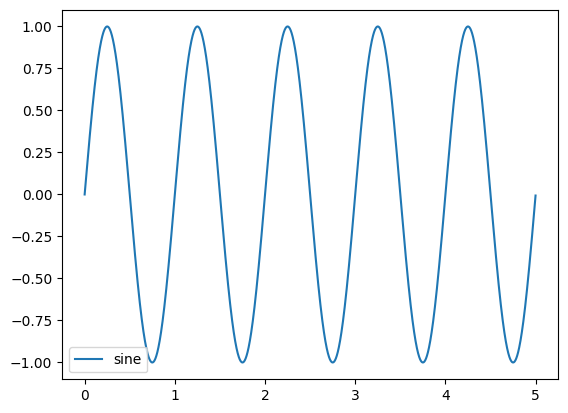

In [264]:
sine_data = pd.read_csv("../datasets/kaggle_data/sine/sine_wave.csv", index_col=0)
plt.plot(sine_data)
plt.legend(["sine"])
plt.show()

In [236]:
output_sine = {}
with tqdm(total=20) as pbar:
    for clk_i, (clk_freq, list_of_f0) in enumerate(clk_resonators.items()):
        print(clk_freq)
        sliced_data_resampled = resample_signal(clk_freq, 1000, sine_data)
        output_sine[clk_freq] = []
        for f_i, f0 in enumerate(list_of_f0):
            resonator = create_excitatory_inhibitory_resonator(
                freq0=f0,
                clk_freq=clk_freq)
            resonator.log_out_spikes(-1)
            output_neuron = resonator.layers_neurons[-1].neurons[-1]
            # append 5 seconds of zero to make the resonator converge.
            resonator.input_full_data(np.zeros(clk_freq * 5))
            resonator.input_full_data(sliced_data_resampled)
            # extract the spikes without the appended zeros
            output_sine[clk_freq].append(output_neuron.out_spikes())
            pbar.update(1)

with open('../datasets/kaggle_data/sine/sine_data_output.pickle', 'wb') as f:
    pickle.dump(output, f, protocol=pickle.HIGHEST_PROTOCOL)

  0%|          | 0/20 [00:00<?, ?it/s]

15360


 25%|██▌       | 5/20 [00:09<00:24,  1.64s/it]

30720


 45%|████▌     | 9/20 [00:21<00:29,  2.71s/it]

61440


 70%|███████   | 14/20 [00:50<00:32,  5.36s/it]

122880


 95%|█████████▌| 19/20 [01:51<00:05,  5.85s/it]


In [231]:
import pickle

with open('../datasets/kaggle_data/sine/sine_data_output.pickle', 'rb') as f:
    output_sine = pickle.load(f)

(5000, 1)
(2103, 1)


ValueError: object too deep for desired array

15360 <class 'str'>
153583
151584
15360 <class 'str'>
151643
149644
15360 <class 'str'>
148266
146267
15360 <class 'str'>
153384
151385
15360 <class 'str'>
153550
151551


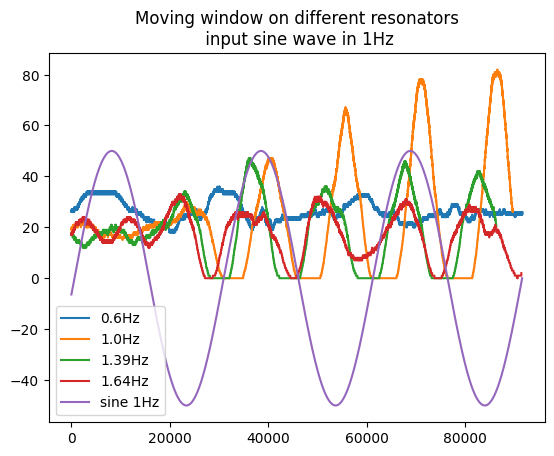

In [310]:
# for clk_freq in clk_resonators:
clk_freq = 15360
f_list = []
for i, freq in enumerate(clk_resonators[clk_freq]):
    print(clk_freq, type(freq))
    y_spikes = create_spikes_list(output_sine[clk_freq][i])
    print(len(y_spikes))
    y_spikes = np.convolve(y_spikes, np.ones(2000, dtype=int), 'valid')
    print(len(y_spikes))
    if(i < 4):
        f_list.append(f'{freq}Hz')
        plt.plot(y_spikes[60000:])
amplitude = 50.0
frequency = 1.0  # Frequency in Hz
duration = 5.0  # Duration in seconds
sampling_rate = len(y_spikes)/ (duration)  # Samples per second

# Time axis
t = np.linspace(0, duration, int(duration * sampling_rate), endpoint=False)

# Generate the sine wave
waveform = amplitude * np.sin(2 * np.pi * frequency * t)
plt.plot(waveform[60000:])
f_list.append('sine 1Hz')
sine_data = pd.read_csv("../datasets/kaggle_data/sine/sine_wave.csv", index_col=0)
plt.legend(f_list)
plt.title('Moving window on different resonators\n input sine wave in 1Hz')
plt.show()